# Tutorial on how to use the MiRNN to model dynamic microbial communities

This tutorial is organized as follows:

1. Importing necessary libraries and functions 

2. Importing data and formatting requirements 

3. Data processing and scaling 

4. Model fitting

5. Model prediction

### 1. Importing necessary libraries and functions

Start by importing the MiRNN which is a class in armored.models 

In [1]:
from armored.models import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Also need to import functions for preprocessing and scaling data 

In [2]:
from armored.preprocessing import *

Import functions from numpy for basic matrix operations, pandas for dealing with importing data as dataframes, matplotlib for enabling plotting, and scipy for computing statistics

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

### 2. Import data 

Data has to be formatted in a .csv file with column headers organized as 

[Experiments, Time, species_1,..., species_n, metabolite_1, ..., metabolite_m, input_1, input_l]

In [4]:
df = pd.read_csv("Data/2021_02_19_MultifunctionalDynamicData.csv")
df.head(4)

,Experiments,Time,PC_OD,PJ_OD,BV_OD,BF_OD,BO_OD,BT_OD,BC_OD,BY_OD,...,CG_OD,ER_OD,RI_OD,CC_OD,DL_OD,DF_OD,Butyrate,Acetate,Lactate,Succinate
0,PC-BV-BT-BC-BP-EL-FP-CH-AC-BH-CG-ER-RI-DF,0,0.000471,0.0,0.000471,0.0,0.0,0.000471,0.000471,0.0,...,0.000471,0.000471,0.000471,0.0,0.0,0.000471,0.000000,0.000000,28.000000,0.000000
1,PC-BV-BT-BC-BP-EL-FP-CH-AC-BH-CG-ER-RI-DF,16,0.465116,0.0,0.029207,0.0,0.0,0.249717,0.500651,0.0,...,0.024339,0.327601,0.001460,0.0,0.0,0.392830,23.092697,47.849302,18.910852,26.141885
2,PC-BV-BT-BC-BP-EL-FP-CH-AC-BH-CG-ER-RI-DF,32,0.104523,0.0,0.027928,0.0,0.0,0.220107,0.380210,0.0,...,0.020739,0.293384,0.000830,0.0,0.0,0.280111,23.996267,38.915218,17.977137,26.884748
3,PC-BV-BT-BC-BP-EL-FP-CH-AC-BH-CG-ER-RI-DF,48,0.124852,0.0,0.012194,0.0,0.0,0.268268,0.333970,0.0,...,0.023660,0.188188,0.002366,0.0,0.0,0.224952,24.839219,34.325914,19.406971,31.628061


Now that the data is imported, specify the names of species, metabolites, and control (i.e. input) variables 

In [5]:
# define microbial species names
species = np.array(['PC_OD', 'PJ_OD', 'BV_OD', 'BF_OD', 'BO_OD', 'BT_OD', 'BC_OD',
                    'BY_OD', 'BU_OD', 'DP_OD', 'BL_OD', 'BA_OD', 'BP_OD', 'CA_OD',
                    'EL_OD', 'FP_OD', 'CH_OD', 'AC_OD', 'BH_OD', 'CG_OD', 'ER_OD',
                    'RI_OD', 'CC_OD', 'DL_OD', 'DF_OD'])

# define metabolite names 
metabolites = np.array(['Butyrate', 'Acetate', 'Lactate', 'Succinate'])

# this example has no controls / inputs on system 
controls = []

system_variables = np.concatenate((species, metabolites, controls))
system_variables

array(['PC_OD', 'PJ_OD', 'BV_OD', 'BF_OD', 'BO_OD', 'BT_OD', 'BC_OD',
       'BY_OD', 'BU_OD', 'DP_OD', 'BL_OD', 'BA_OD', 'BP_OD', 'CA_OD',
       'EL_OD', 'FP_OD', 'CH_OD', 'AC_OD', 'BH_OD', 'CG_OD', 'ER_OD',
       'RI_OD', 'CC_OD', 'DL_OD', 'DF_OD', 'Butyrate', 'Acetate',
       'Lactate', 'Succinate'], dtype='<U32')

### 3. Data processing and scaling

We'll start by dividing the data into train and test sets 

In [6]:
# specify random train and test samples
treatments = np.unique(df.Experiments.values)

# specify test communities 
n_test = 20
test_set = np.random.choice(treatments, n_test, replace=False)

# pull train and test indices
test_inds = np.in1d(df.Experiments.values, test_set)
train_df  = df.iloc[~test_inds].copy() 
test_df   = df.iloc[test_inds].copy() 

Use the "format_data" function to format a Pandas dataframe into an array with dimensions [n_samples, n_time, n_system variables]

In [7]:
# format data 
train_data, exp_names, N = format_data(train_df, species, metabolites, controls)
test_data, _, _ = format_data(test_df, species, metabolites, controls)

Scale the data according to the training data statistics. The model requires a "Zero Max Scaler", which means that the data are scaled down according to the largest value of each column in the training data. 

In [8]:
# fit a scaler to the training data 
scaler = ZeroMaxScaler().fit(train_data)
train_data = scaler.transform(train_data)
test_data  = scaler.transform(test_data)

### 4. Fit the model to the scaled training data 

In [9]:
# instantiate the model, difining the number of hidden units and the number of samples in the data 
rnn = miRNN(n_species=len(species), n_metabolites=len(metabolites), n_controls=0, n_hidden=16, N=N)

# fit the model
rnn.fit(train_data)

Epoch: 0, Loss: 665.13218, Residuals: -8.84076, Convergence:   inf
Epoch: 10, Loss: 607.05981, Residuals: -8.12969, Convergence: 0.010648
Epoch: 20, Loss: 540.93121, Residuals: -7.39374, Convergence: 0.012040
Epoch: 30, Loss: 479.43832, Residuals: -6.69791, Convergence: 0.012148
Epoch: 40, Loss: 425.55365, Residuals: -6.05745, Convergence: 0.011808
Epoch: 50, Loss: 379.43970, Residuals: -5.47599, Convergence: 0.011220
Epoch: 60, Loss: 340.38962, Residuals: -4.94987, Convergence: 0.010538
Epoch: 70, Loss: 307.50079, Residuals: -4.47475, Convergence: 0.009902
Epoch: 80, Loss: 280.31735, Residuals: -4.05114, Convergence: 0.009107
Epoch: 90, Loss: 257.28595, Residuals: -3.66467, Convergence: 0.008242
Epoch: 100, Loss: 238.02562, Residuals: -3.31552, Convergence: 0.007431
Epoch: 110, Loss: 221.99721, Residuals: -3.00359, Convergence: 0.006683
Epoch: 120, Loss: 208.60889, Residuals: -2.71917, Convergence: 0.005964
Epoch: 130, Loss: 197.38615, Residuals: -2.46279, Convergence: 0.005272
Epoch:

### 5. Make predictions on held out test data

In [10]:
# rnn.predict returns predictions, standard deviation for each prediction, and output covariance
preds, stdvs, COV = rnn.predict(test_data)

Transform values back to original scale

In [11]:
preds = scaler.inverse_transform(preds)
stdvs = scaler.inverse_transform_stdv(stdvs)
# COV   = scaler.inverse_transform_cov(COV)
test_data = scaler.inverse_transform(test_data)

Plot example trajectory over time

In [12]:
# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (16, 12),
          'lines.linewidth': 4,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':5,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

Run the following cell to see predictions on randomly selected samples from the test set

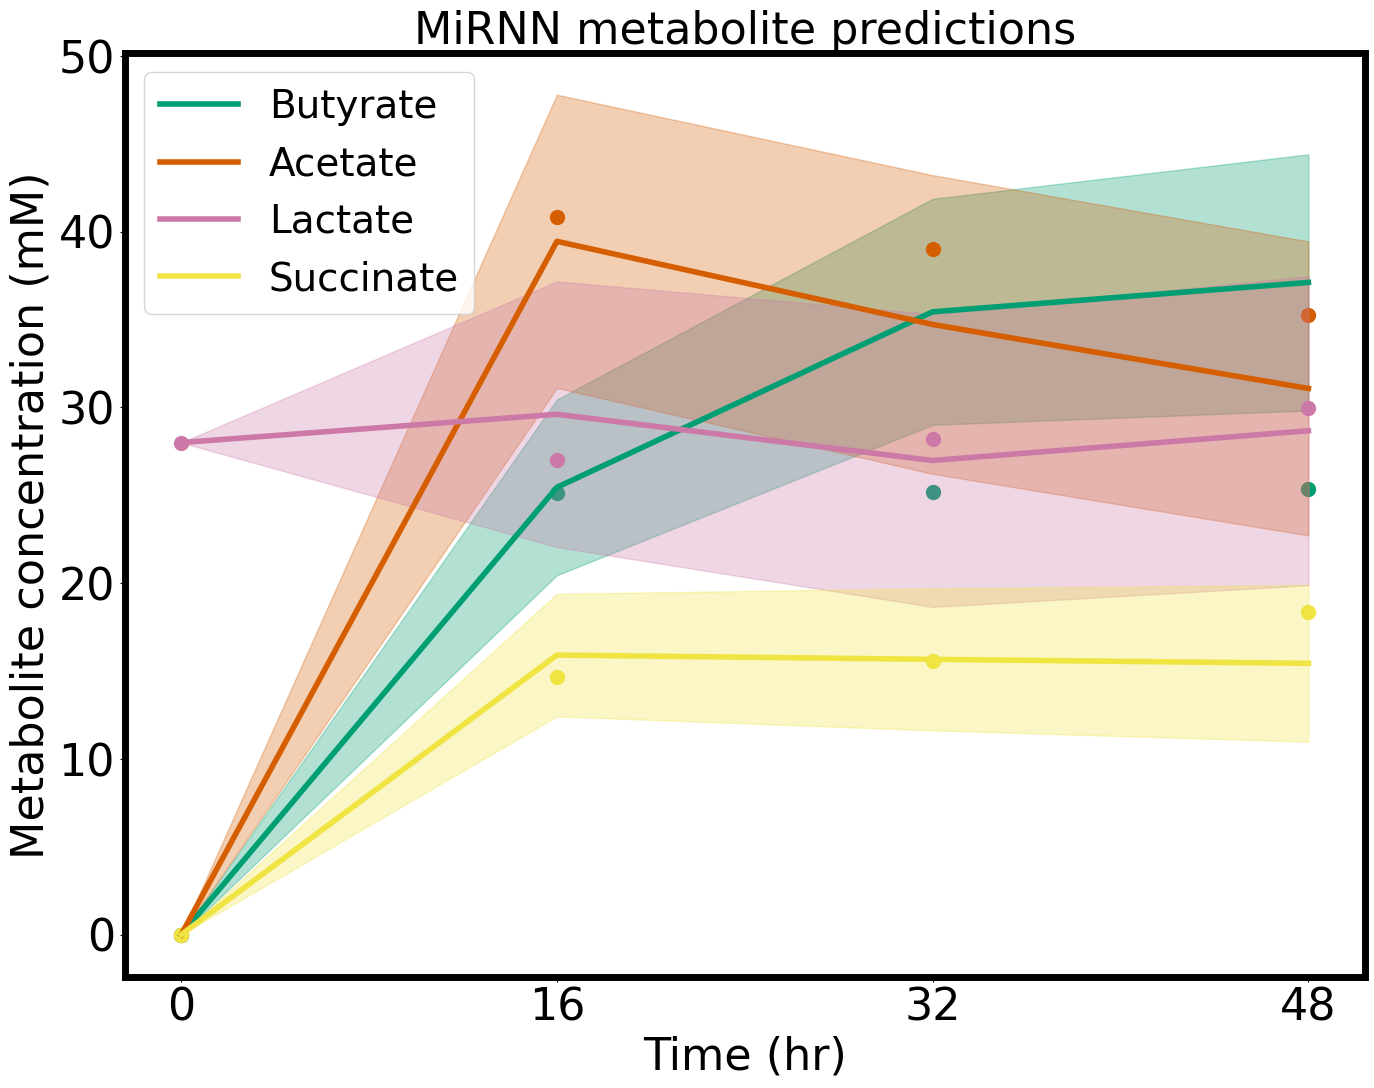

In [16]:
exp_ind = np.random.choice(np.arange(test_data.shape[0]))
t_span = [0, 16, 32, 48]

for i, variable in enumerate(metabolites):
    var_ind = np.in1d(system_variables, variable)
    plt.scatter(t_span, test_data[exp_ind, :, var_ind].ravel(), color='C{}'.format(i+1), 
                s=100)
    plt.plot(t_span, preds[exp_ind, :, var_ind].ravel(), label=f"{variable}", color='C{}'.format(i+1))
    plt.fill_between(t_span, preds[exp_ind, :, var_ind].ravel() - stdvs[exp_ind, :, var_ind].ravel(), 
                     preds[exp_ind, :, var_ind].ravel() + stdvs[exp_ind, :, var_ind].ravel(), 
                     color='C{}'.format(i+1), alpha=.3)
plt.legend(fontsize=28)
plt.xticks(t_span, fontsize=32)
plt.xlabel("Time (hr)", fontsize=32)
plt.yticks(fontsize=32)
plt.ylabel("Metabolite concentration (mM)", fontsize=32)
plt.title("MiRNN metabolite predictions", fontsize=32)
plt.show()